#  Прогнозирование заказов такси

Для компании «Чётенькое такси» нужно построить модель предсказания количества заказов такси на следующий час в период пиковой нагрузки.  
Точность модели нужно определять с помощью метрики *RMSE* на тестовой выборке, значение которой не должно быть больше 48.

## Подготовка

### Установим пакеты бустинга и импортируем библиотеки

In [1]:
!pip install catboost
!pip install lightgbm
!pip install statsmodels
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

In [3]:
rs = 12345
cv = TimeSeriesSplit(n_splits = 5)

### Загрузим и оценим данные

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [5]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
df.describe(include='all')

,datetime,num_orders
count,26496,26496.000000
unique,26496,NaN
top,2018-03-01 00:00:00,NaN
freq,1,NaN
mean,NaN,14.070463
std,NaN,9.211330
min,NaN,0.000000
25%,NaN,8.000000
50%,NaN,13.000000
75%,NaN,19.000000


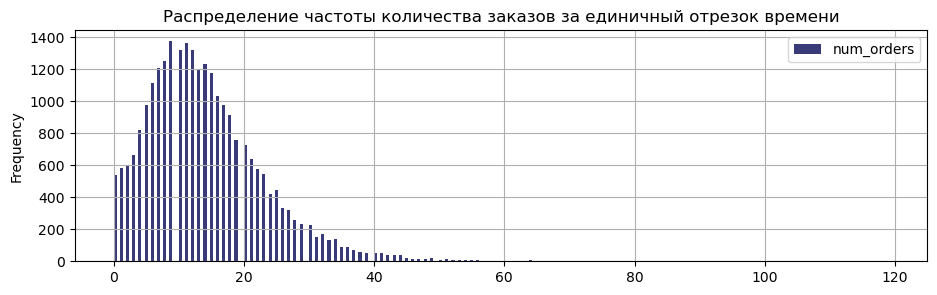

In [8]:
df.plot.hist(
    grid=True, 
    figsize=(11,3),
    colormap= 'tab20b',
    title='Распределение частоты количества заказов за единичный отрезок времени', 
    ylabel='количество заказов', 
    xlabel='дата',
    bins=250
)
plt.show()

In [9]:
(df.isna().mean() * 100).round(2)

datetime      0.0
num_orders    0.0
dtype: float64

In [10]:
df.duplicated().sum()

0

#### Вывод

Исходные данные состоят из 26496 строк и 2 колонок:
 - datetime - Временная метка.
 - num_orders - Количество заказов.

Исходные данные не содержат пропусков и дубликатов.

## Анализ

Переведем столбец datetime к типу datetime64[ns]

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс датафрейма равным столбцу datetime и произведем сортировку, проверим результат

In [14]:
df = df.set_index('datetime').sort_index()
df.index.is_monotonic

True

Оценим распределение заказов по времени

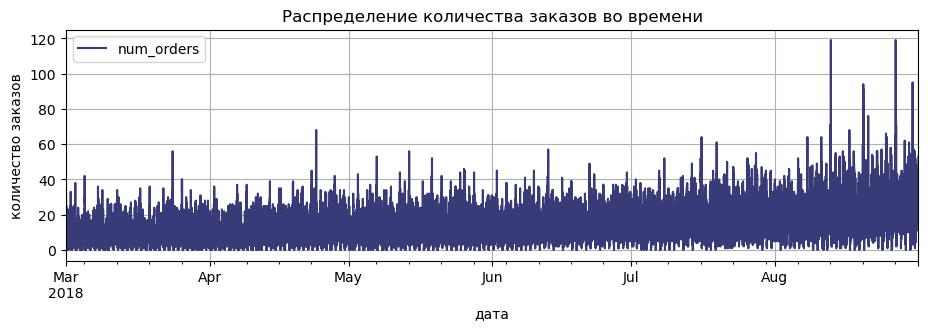

In [15]:
df.plot(
    grid=True, 
    figsize=(11,3),
    colormap= 'tab20b',
    title='Распределение количества заказов во времени', 
    ylabel='количество заказов', 
    xlabel='дата'
)
plt.show()

In [16]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [17]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Вероятно данные разбиты на промежутки по 10 минут. Срез данных взят с 2018-03-01 00:00:00 по 2018-08-31 23:50:00

Выполним ресемплинг по 1 часу и сглаживание временного ряда методом скользящего среднего. Для наглядности построим график.

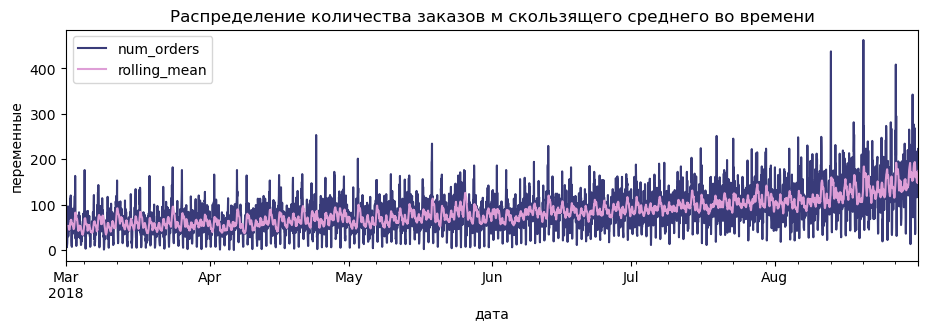

In [18]:
df = df.resample('1H').sum()
df["rolling_mean"] = df["num_orders"].rolling(15).mean()
df.plot(
    figsize=(11,3),
    colormap= 'tab20b',
    title='Распределение количества заказов м скользящего среднего во времени', 
    ylabel='переменные', 
    xlabel='дата'
)
plt.show()

Оценим тренд и сезонность:

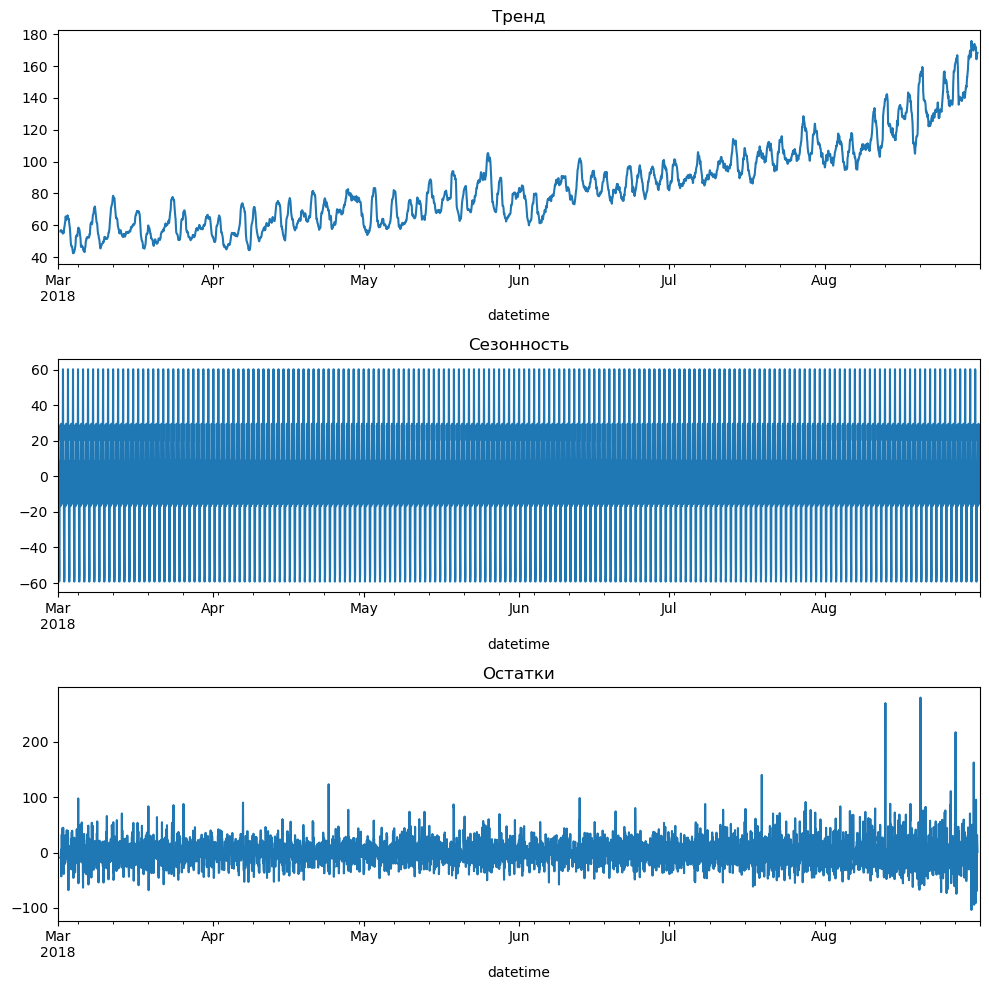

In [19]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(10,10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

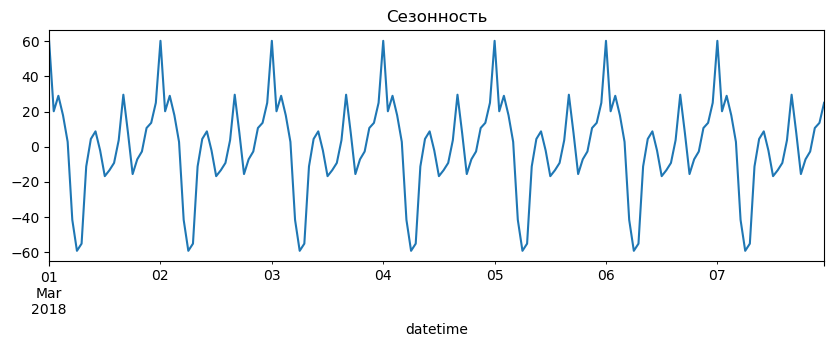

In [20]:
plt.figure(figsize=(10,3))
decomposed.seasonal.head(24*7).plot(title='Сезонность');

Мы видим посуточную сезонность и выраженный тренд на увеличение количества заказов.

С мая идет плавное изменение среднего значения ряда  
Суточная сезонность остается неизменной на протяжении всего исследуемого периода  
Наблюдается пик заказов в начале каждого дня, затем к утру резкое падение и к вечеру количество заказов снова растет и достигает нового пика  

Оценим стационарность с помощью теста ADF (расширенный тест Дики – Фуллера):

In [21]:
adfuller(df['num_orders'])

(-3.0689242890279265,
 0.028940051402615248,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

p-значение (0.0289) менее 0.05, значит H0 (ряд не стационарный) можно отвергнуть. Это значит, что временной ряд является стационарным.

### Вывод

Мы перевели столбец datetime к типу datetime64[ns], установили его индексом датафрейма и провели сортировку.

Мы выполнили ресемплинг по 1 часу и сглаживание временного ряда методом скользящего среднего. Для наглядности построили график.

Оценили тренд и сезонность: сезонность посуточная, а тренд выраженный на увеличение количества заказов.

С помощью теста ADF (расширенный тест Дики – Фуллера), мы определили, что временной ряд является стационарным.

## Обучение моделей

Создадим таблицу с результатами обучения для каждой модели. Результаты будут отражать важные для заказчика параметры: качество предсказания. Для идентификации модели добавим название и параметры модели.

In [22]:
models = pd.DataFrame(columns =   ['model_name', 'model_var', 'fit_time', 'predict_time', 'full_time', 'rmse_train'])
display(models)

,model_name,model_var,fit_time,predict_time,full_time,rmse_train


Напишим функцию, которая будет сохранять результаты обучения модели в итоговую таблицу.

In [23]:
def models_result (model_name, model_var, fit_time, predict_time, full_time, rmse, models):
    result = [model_name, model_var, fit_time, predict_time, full_time, rmse]
    rows = [pd.Series(result, index = models.columns)]
    models = models.append(rows,ignore_index=True)
    return(models)

Напишим функцию, которая будет считать точность модели по среднеквадратической ошибке (RMSE).

In [24]:
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))

rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)

Напишим функцию, обучения и предсказания точности модели.

In [25]:
def fit_model(model, features_train, target_train):

    rmse = round(np.mean(np.sqrt(np.abs(cross_val_score(model, features_train, target_train, scoring="neg_mean_squared_error")))), 2)
    
    fit_start = time.time()
    model.fit(features_train, target_train)
    fit_time = round(time.time() - fit_start, 1)

    predict_start = time.time()
    predicted_train = model.predict(features_train)
    predict_time = round(time.time() - predict_start, 1)
    
    full_time = fit_time + predict_time

    return(rmse, fit_time, predict_time, full_time)

### Подготовка признаков

In [26]:
df = df.drop('rolling_mean', axis = 1)
df_p = df.copy()
df_m = df.copy()
print(df.head())
print(df.info())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


Признак год - это константа, на нем невозможно обучить модель.  
Признак месяца - это тоже практически константа, влияние на модель, возможно, и будет, но настолько незначительное, что им тоже можно принебречь.  
Признак дня - имеется тенденция расти с течением времени.  
Признак дня недели - играет одну из самых важных ролей, ибо данные исходя из него сильно варьируются.
Признак часа - играет самую важную роль, так как у нас прогнозирование на час вперед. На его фоне выделили сезонность, где есть очень важные часы пиков и минимумов.
Дополнительно добавили 3 фактора: абсолютную разницу с предыдущим значением, скользащее среднее и стандартное отклонение. Еще добавил признак выходных дней.

Напишим функцию для подготовки признаков:

In [28]:
def make_features(data, max_lag, rolling_mean_size):

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['diff'] = abs(df['num_orders'].diff())
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df, 150, 5)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2560750432.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2560750432.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2560750432.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

Напишим функцию, которая будет маркировать выходные дни:

In [29]:
def is_dayoff(row):
    if row['dayofweek'] >= 5:
        return 1
    else:
        return 0

In [30]:
df['is_dayoff'] = df.apply(is_dayoff, axis=1)

In [31]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=rs)
train = train.dropna()

features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

In [32]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3824, 157)
(442, 157)
(3824, 1)
(442, 1)


### Linear Regression

In [33]:
model_lr = LinearRegression()
model_name = "Linear Regression"

In [34]:
model_var = np.nan

In [35]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_lr,
    features_train, 
    target_train)

Wall time: 157 ms


In [36]:
models = models_result(model_name, model_var, fit_time, predict_time, full_time, rmse, models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [37]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95


### Decision Tree

In [38]:
model_dt = DecisionTreeRegressor(random_state = rs)
model_name = "Decision Tree"

In [39]:
param_dt = {
#    'max_depth': range(1, 25, 1),    
    'max_depth': [5],
    'random_state': [rs]
} 

In [40]:
grid_dt = GridSearchCV(
    estimator = model_dt,
    param_grid = param_dt,
    scoring = rmse_scoring,
    verbose = True,
    n_jobs = -1,
    cv = cv
)

In [41]:
%%time
grid_dt.fit(features_train, target_train)
grid_dt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 3.46 s


{'max_depth': 5, 'random_state': 12345}

In [42]:
model_dt = DecisionTreeRegressor(**grid_dt.best_params_)

In [43]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_dt,
    features_train, 
    target_train)

Wall time: 735 ms


In [44]:
model_var = grid_dt.best_params_
del model_var['random_state']
model_var

{'max_depth': 5}

In [45]:
models = models_result(model_name, model_var, fit_time, predict_time, full_time, rmse, models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [46]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54


### Random Forest

In [47]:
model_rf = RandomForestRegressor(random_state = rs)
model_name = "Random Forest"

In [48]:
param_rf = {
#    'n_estimators': range(1, 100, 1),
    'n_estimators': [96],
#    'max_depth': range(1, 25, 1),
    'max_depth': [18],
    'random_state': [rs],
}

In [49]:
grid_rf = GridSearchCV(
    estimator = model_rf,
    param_grid = param_rf,
    scoring = rmse_scoring,
    verbose = True,
    n_jobs = -1,
    cv = cv
)

In [50]:
%%time
grid_rf.fit(features_train, target_train)
grid_rf.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Wall time: 42 s


{'max_depth': 18, 'n_estimators': 96, 'random_state': 12345}

In [51]:
model_rf = RandomForestRegressor(**grid_rf.best_params_)

In [52]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_rf,
    features_train, 
    target_train
)

C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A co

Wall time: 1min 47s


In [53]:
model_var = grid_rf.best_params_
del model_var['random_state']
model_var

{'max_depth': 18, 'n_estimators': 96}

In [54]:
models = models_result(model_name, model_var, fit_time, predict_time, full_time, rmse, models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [55]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94


### LightGBM

In [56]:
model_lgbm = LGBMRegressor(random_state = rs)
model_name = "LightGBM"

In [57]:
parameters_lgbm = {
#    'num_leaves': range(1, 25, 1),  
    'num_leaves': [21],
    'learning_rate': [0.1],
#    'max_depth': range(1, 10, 1),   
    'max_depth': [8],
    'random_state': [rs]
}

In [58]:
grid_lgbm = GridSearchCV(
    estimator = model_lgbm, 
    param_grid = parameters_lgbm, 
    scoring = rmse_scoring, 
    n_jobs = -1, 
    verbose = 1,
    cv = cv
)

In [59]:
%%time
grid_lgbm.fit(features_train, target_train)
grid_lgbm.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 2.57 s


{'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 21, 'random_state': 12345}

In [60]:
model_lgbm = LGBMRegressor(**grid_lgbm.best_params_) 

In [61]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_lgbm,
    features_train, 
    target_train
)

Wall time: 1.71 s


In [62]:
model_var = grid_lgbm.best_params_
del model_var['random_state']
model_var

{'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 21}

In [63]:
models = models_result(model_name, model_var, fit_time, predict_time, full_time, rmse, models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [64]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'num_le...",0.3,0.0,0.3,18.61


### CatBoost

In [65]:
model_cb = CatBoostRegressor(random_state = rs)
model_name = "CatBoost"

In [66]:
parameters_cb = {
#    'depth': range(1,25,1),
    'depth': [5],
    'learning_rate': [0.1],
    'metric_period': [100],
    'random_state': [rs],
    'silent': [True],
    'loss_function': ['RMSE']
} 

In [67]:
grid_cb = GridSearchCV(
    estimator = model_cb, 
    param_grid = parameters_cb, 
    scoring = rmse_scoring,
    n_jobs = -1, 
    verbose = 1,
)

In [68]:
%%time
grid_cb.fit(features_train, target_train)
grid_cb.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 30.4 s


{'depth': 5,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'metric_period': 100,
 'random_state': 12345,
 'silent': True}

In [69]:
model_cb = CatBoostRegressor(**grid_cb.best_params_) 

In [70]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_cb,
    features_train, 
    target_train,
)

Wall time: 37.2 s


In [71]:
model_var = grid_cb.best_params_
del model_var['random_state']
model_var

{'depth': 5,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'metric_period': 100,
 'silent': True}

In [72]:
models = models_result(model_name, model_var, fit_time, predict_time, full_time, rmse, models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [73]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'num_le...",0.3,0.0,0.3,18.61
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1, 'loss_funct...",6.3,0.0,6.3,18.24


### Prophet

In [74]:
model_p = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
model_name = "Prophet"

In [75]:
df_p = df_p.reset_index().rename(columns = {'datetime': 'ds', 'num_orders': 'y'})

In [76]:
print(df_p.head())
print(df_p.info())

                   ds    y
0 2018-03-01 00:00:00  124
1 2018-03-01 01:00:00   85
2 2018-03-01 02:00:00   71
3 2018-03-01 03:00:00   66
4 2018-03-01 04:00:00   43
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4416 non-null   datetime64[ns]
 1   y       4416 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 69.1 KB
None


In [77]:
df_p_train, df_p_test = train_test_split(df_p, shuffle=False, test_size=0.1, random_state=rs)

In [78]:
print(df_p_train.shape)
print(df_p_train.tail(2))
print(df_p_test.shape)
print(df_p_test.head(2))

(3974, 2)
                      ds    y
3972 2018-08-13 12:00:00   92
3973 2018-08-13 13:00:00  119
(442, 2)
                      ds    y
3974 2018-08-13 14:00:00  102
3975 2018-08-13 15:00:00  175


In [79]:
param_grid = {  
    'changepoint_prior_scale': [ 0.01, 0.1],
    'seasonality_prior_scale': [100, 500]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

for params in all_params:
    model_p = Prophet(**params, daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative').fit(df_p_train)
    p_cv = cross_validation(model_p, horizon='30 days', parallel="processes")
    p_p = performance_metrics(p_cv, rolling_window=1)
    rmses.append(p_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

best_params = all_params[np.argmin(rmses)]
print(best_params)

15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:43 - cmdstanpy - INFO - Chain [1] done processing
15:32:48 - cmdstanpy - INFO - Chain [1] start processing
15:32:49 - cmdstanpy - INFO - Chain [1] done processing
15:32:53 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing
15:32:59 - cmdstanpy - INFO - Chain [1] start processing
15:32:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 500}


In [80]:
model_p = Prophet(**best_params, daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative').fit(df_p_train)

15:33:05 - cmdstanpy - INFO - Chain [1] start processing
15:33:05 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
df_p_future = model_p.make_future_dataframe(freq = 'H', periods = len(df_p_test))
df_p_future.tail()

,ds
4411,2018-08-31 19:00:00
4412,2018-08-31 20:00:00
4413,2018-08-31 21:00:00
4414,2018-08-31 22:00:00
4415,2018-08-31 23:00:00


In [82]:
df_p_forecast = model_p.predict(df_p_future)
df_p_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4411,2018-08-31 19:00:00,121.732724,90.463909,155.028066
4412,2018-08-31 20:00:00,132.077819,100.414313,162.646277
4413,2018-08-31 21:00:00,155.077037,122.269841,185.305963
4414,2018-08-31 22:00:00,175.535419,144.361962,208.206996
4415,2018-08-31 23:00:00,185.920640,155.392786,215.791623


In [83]:
model_var = best_params
models = models_result(model_name, model_var, fit_time, predict_time, full_time, round(p_p['rmse'].min(),2), models)

C:\Users\Lysergide\AppData\Local\Temp\ipykernel_64504\2421855381.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


In [84]:
models

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'num_le...",0.3,0.0,0.3,18.61
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1, 'loss_funct...",6.3,0.0,6.3,18.24
5,Prophet,"{'changepoint_prior_scale': 0.01, 'seasonality...",6.3,0.0,6.3,29.22


### Вывод

In [86]:
models.sort_values('rmse_train')

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1, 'loss_funct...",6.3,0.0,6.3,18.24
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'num_le...",0.3,0.0,0.3,18.61
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
5,Prophet,"{'changepoint_prior_scale': 0.01, 'seasonality...",6.3,0.0,6.3,29.22


Мы обучили 6 моделей и сравнили их точность с помощью среднеквадратической ошибки. CatBoost показала лучший результат.

## Тестирование лучшей модели

Функция построения графика сравнения результата предсказания модели на тестовой выборке с тестовой выборкой.

In [87]:
def graph(model_id):
    target_predict = model_id.predict(features_test)
    
    plt.figure(figsize=(15,5), dpi=150)
    
    plt.plot(np.array(target_test, np.int32), color = '#1dacd6', label = 'Target test data')
    plt.plot(np.array(target_predict, np.int32), color = '#c10020', label='Model predict data')
    plt.legend()
    plt.show()
    
    (rmse, fit_time, predict_time, full_time) = fit_model(
    model_id,
    features_test, 
    target_test,
    )
    print("RMSE модели на тестовой выборке:", rmse)

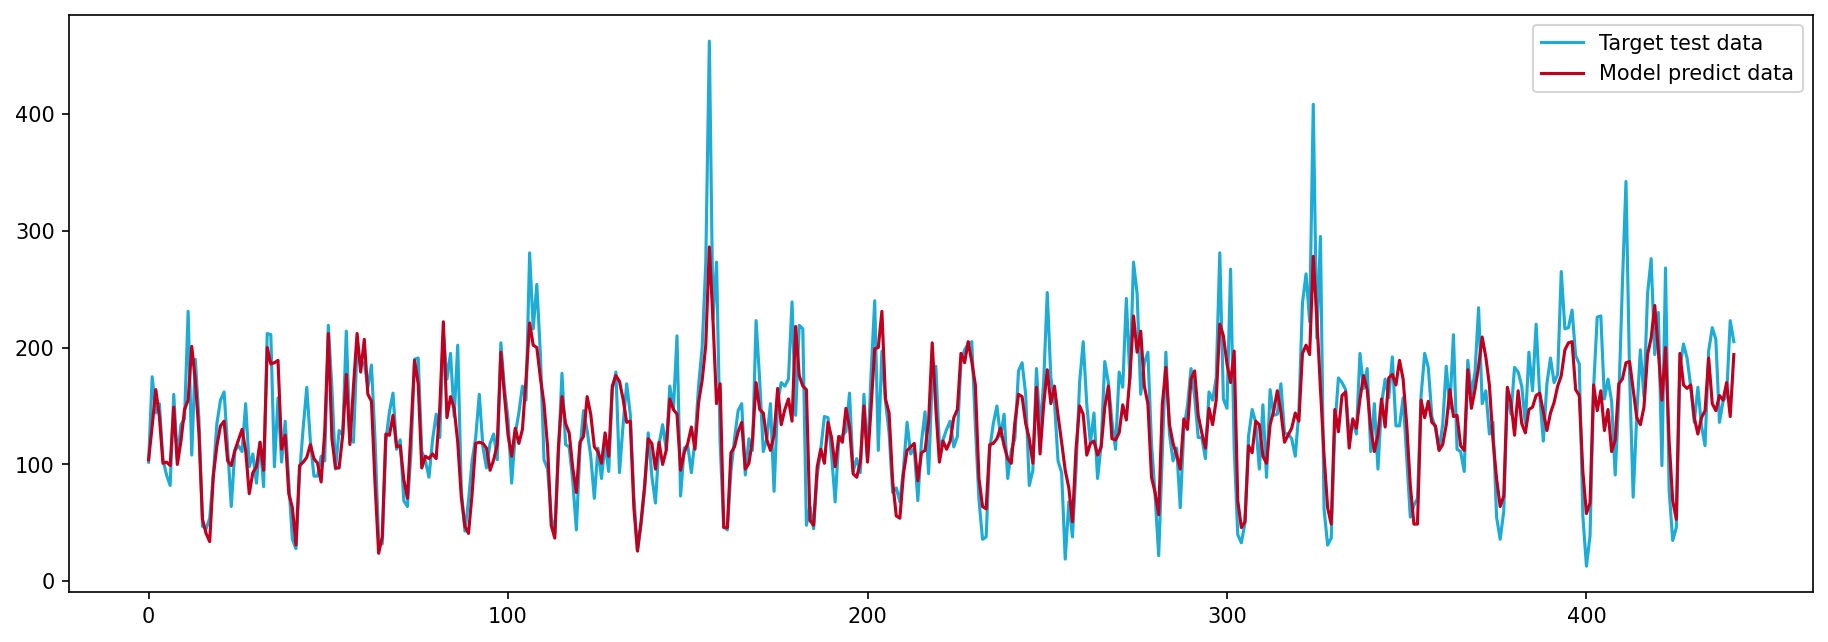

RMSE модели на тестовой выборке: 36.78


In [88]:
graph(model_cb)

RMSE соответствует условию задачи

## Тестирование альтернативных моделей

Т.к. LightGBM тоже показала хороший результат, при этом обучается и предсказывает в разы быстрее CatBoost, предлагаю рассмотреть её как альтернативную модель.

### Linear Regression

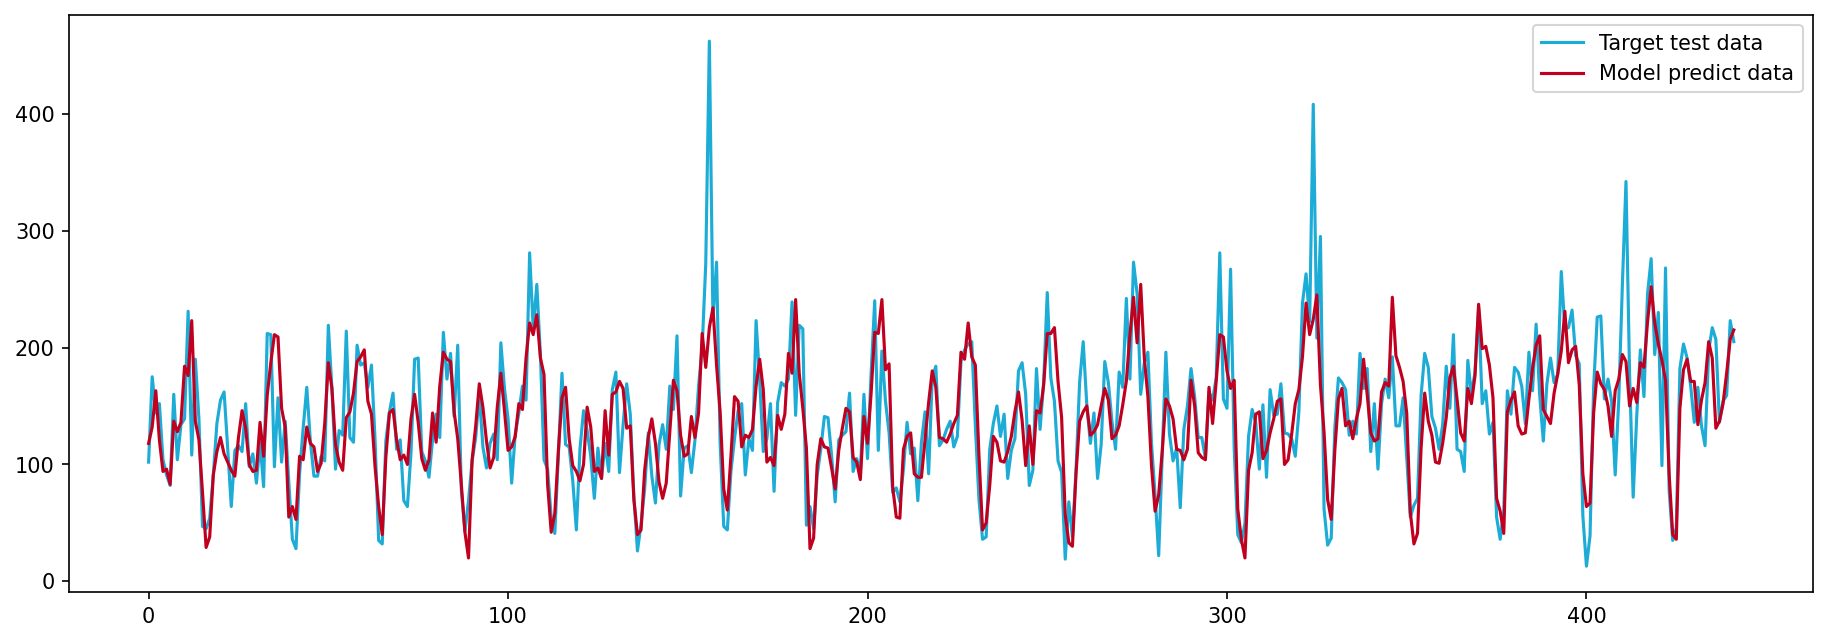

RMSE модели на тестовой выборке: 56.71


In [89]:
graph(model_lr)

### Decision Tree

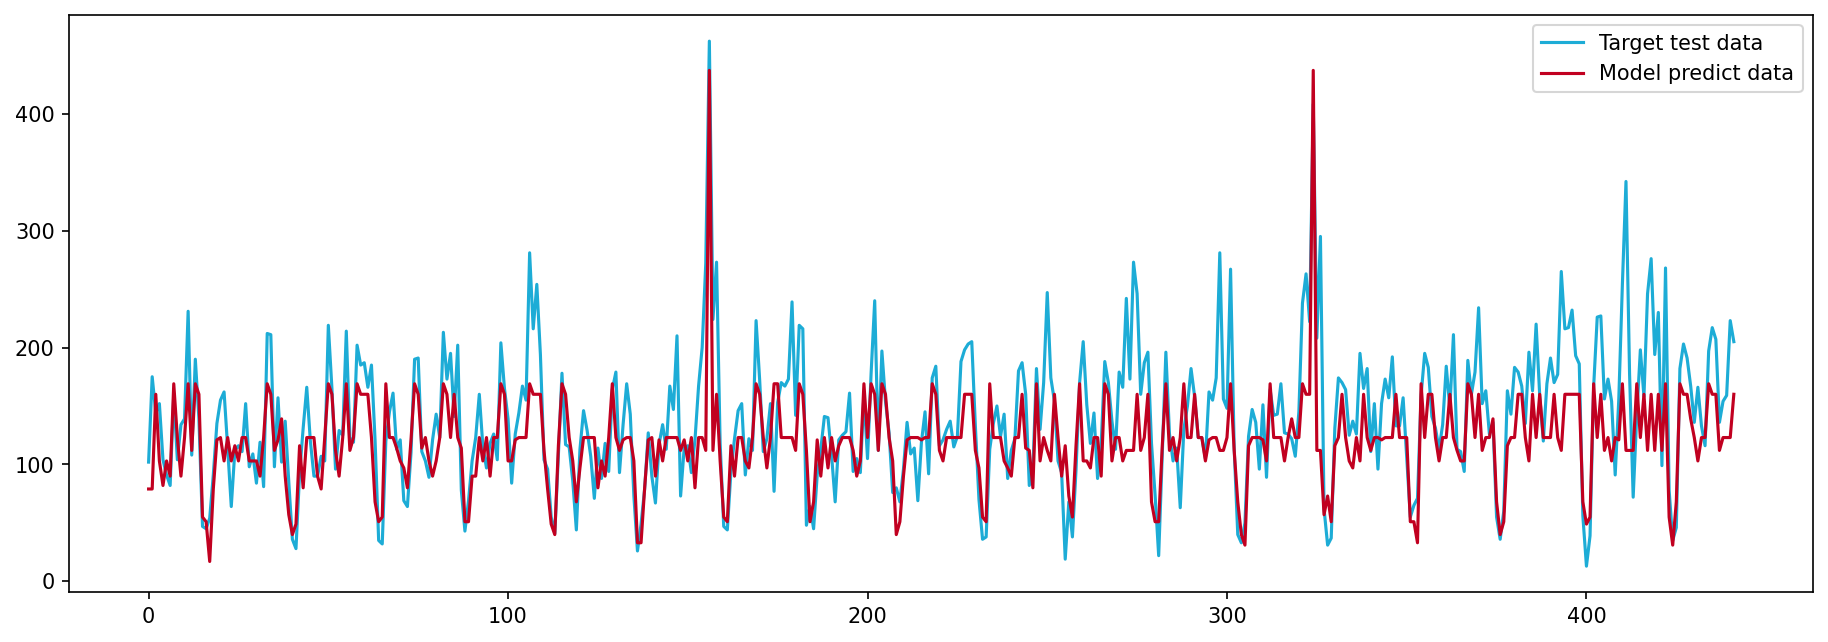

RMSE модели на тестовой выборке: 49.14


In [90]:
graph(model_dt)

### Random Forest

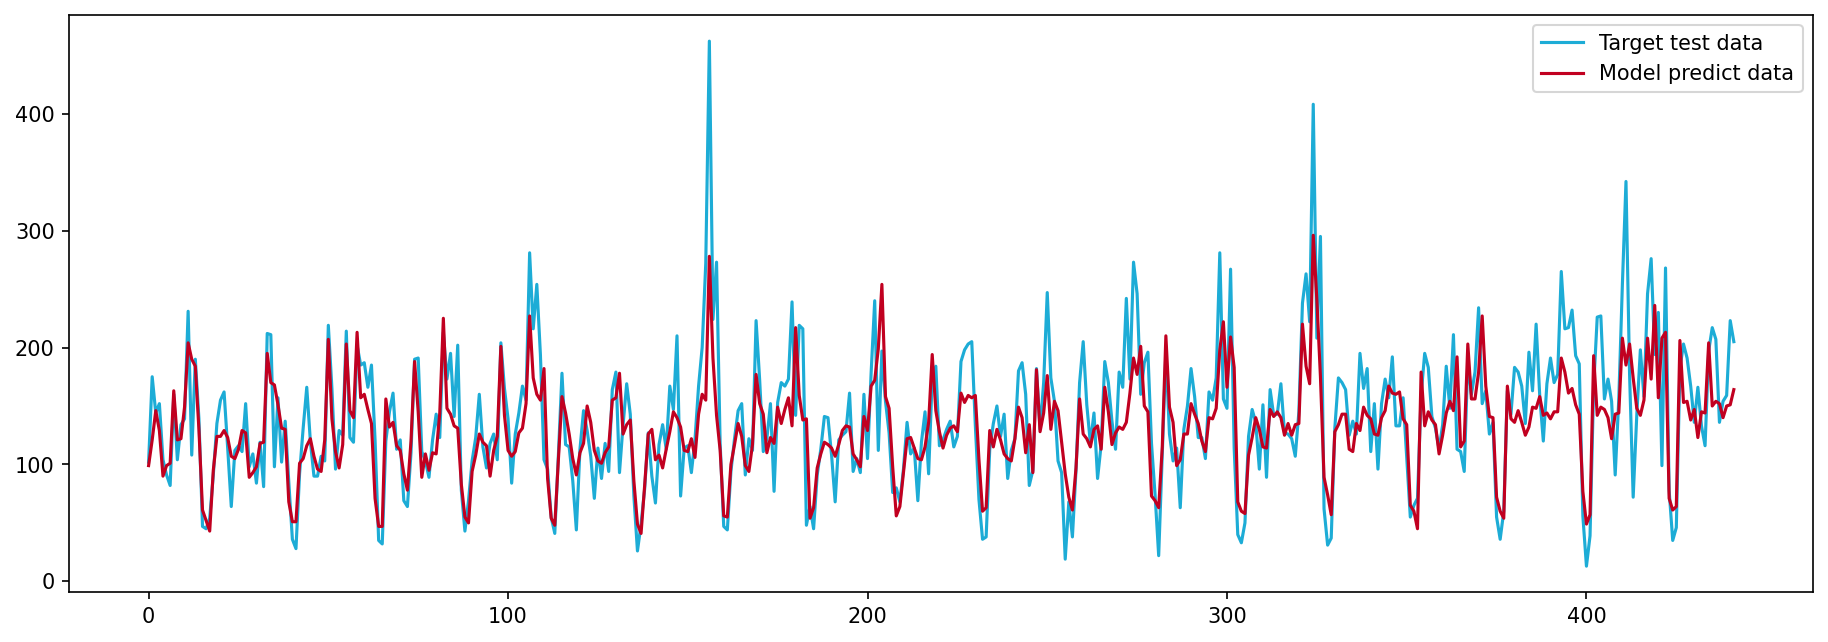

C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lysergide\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A co

RMSE модели на тестовой выборке: 38.32


In [91]:
graph(model_rf)

### LightGBM

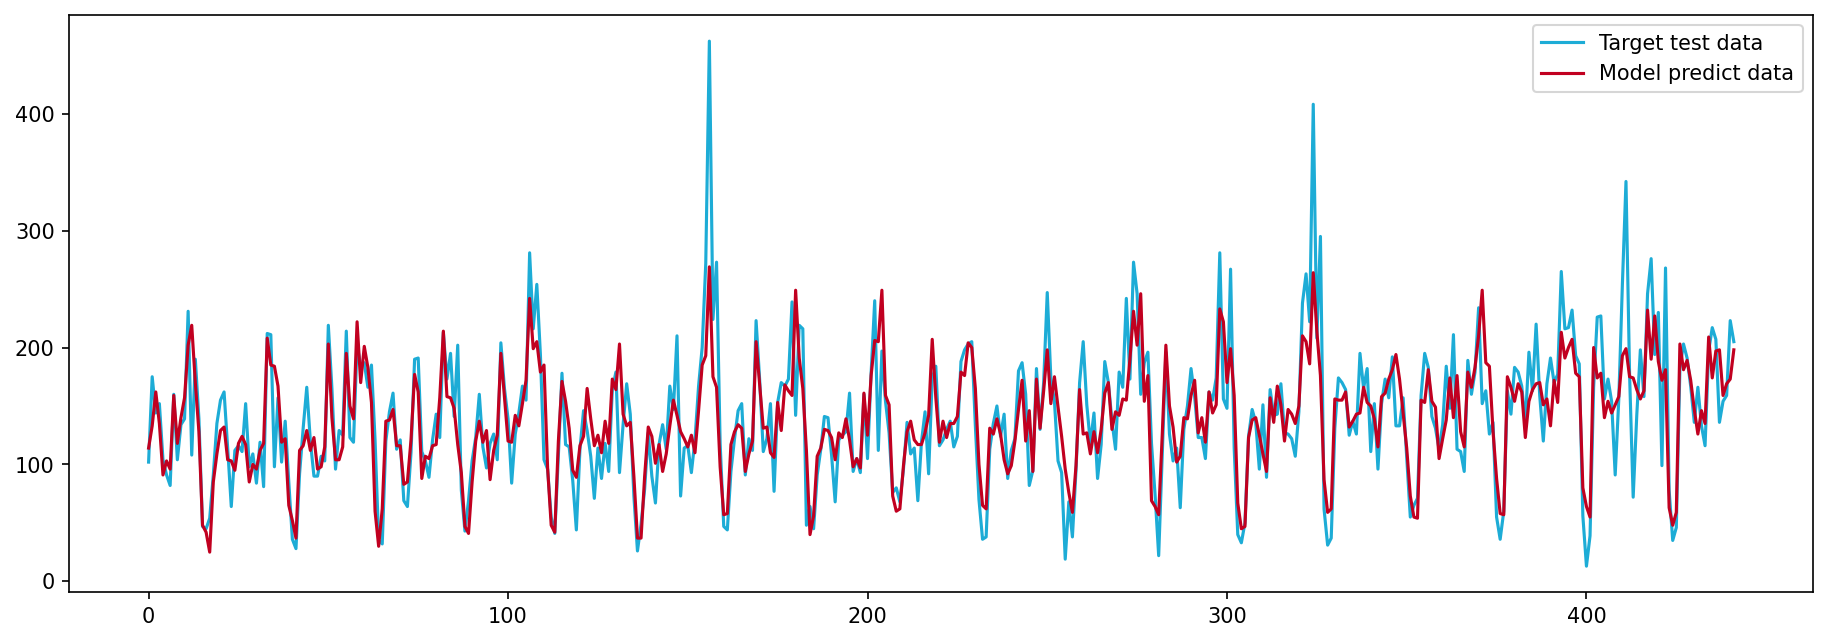

RMSE модели на тестовой выборке: 35.99


In [92]:
graph(model_lgbm)

### Prophet

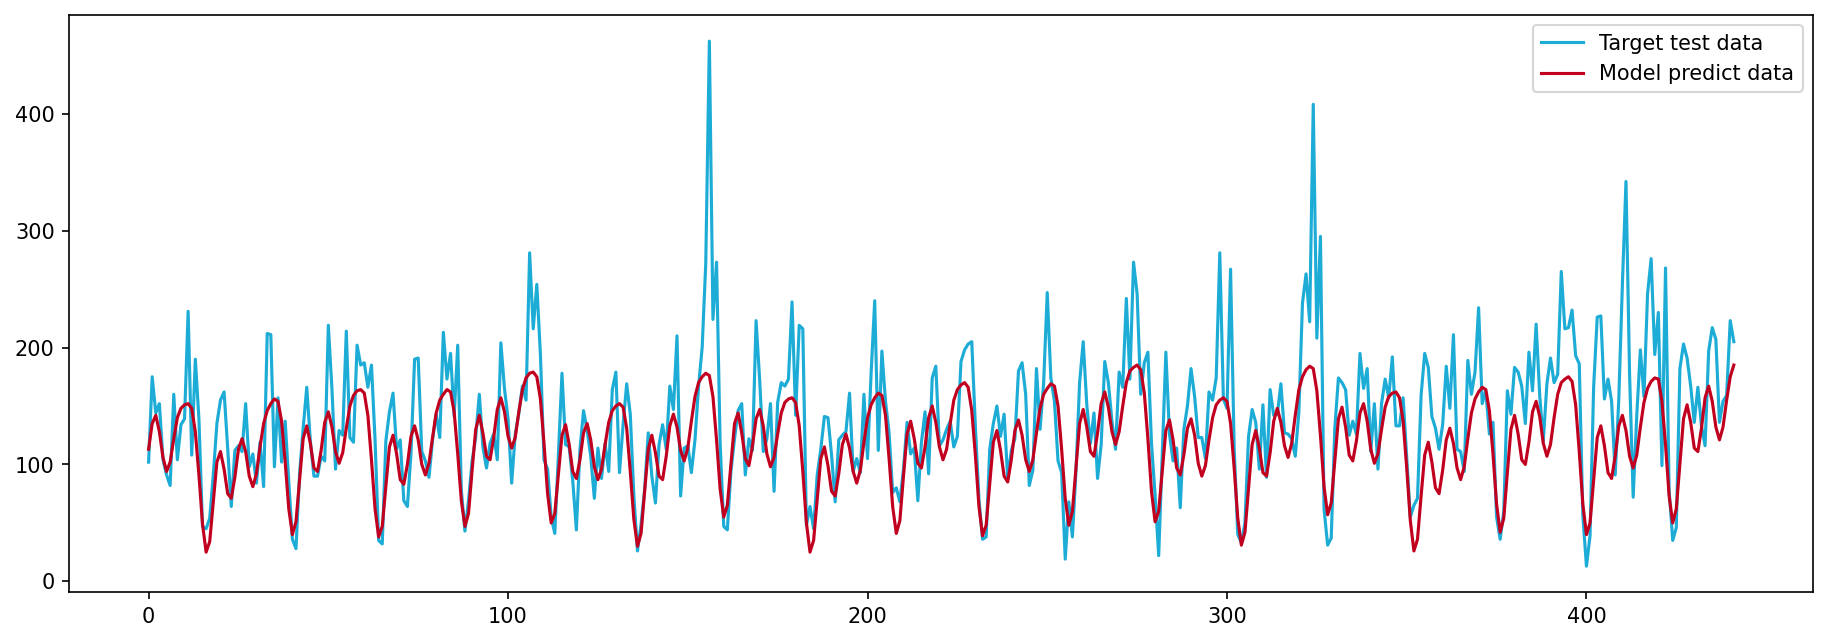

RMSE модели на тестовой выборке: 45.78


In [93]:
target_predict = df_p_forecast['yhat'].tail(len(df_p_test))

plt.figure(figsize=(15,5), dpi=150)

plt.plot(np.array(target_test, np.int32), color = '#1dacd6', label = 'Target test data')
plt.plot(np.array(target_predict, np.int32), color = '#c10020', label='Model predict data')
plt.legend()
plt.show()

print("RMSE модели на тестовой выборке:", round(rmse_scorer(df_p_test['y'], df_p_forecast['yhat'].tail(len(df_p_test))),2))

## Общий Вывод

Исходные данные состоят из 26496 строк и 2 колонок:
 - datetime - Временная метка.
 - num_orders - Количество заказов.

Исходные данные не содержат пропусков и дубликатов.

Мы перевели столбец datetime к типу datetime64[ns], установили его индексом датафрейма и провели сортировку.  
Мы выполнили ресемплинг по 1 часу и сглаживание временного ряда методом скользящего среднего. Для наглядности построили график.  
Оценили тренд и сезонность: с мая идет плавное изменение среднего значения ряда, суточная сезонность остается неизменной на протяжении всего исследуемого периода, наблюдается пик заказов в начале каждого дня, затем к утру резкое падение и к вечеру количество заказов снова растет и достигает нового пика.  
С помощью теста ADF (расширенный тест Дики – Фуллера), мы определили, что временной ряд является стационарным.

Мы отсортировали признаки. Убрали ненужные (месяц) и добавили новые (выходной день, абсолютную разницу с предыдущим значением, скользащее среднее и стандартное отклонение).

Мы обучили 6 моделей и сравнили их точность с помощью среднеквадратической ошибки.

In [94]:
models.sort_values('rmse_train')

,model_name,model_var,fit_time,predict_time,full_time,rmse_train
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1, 'loss_funct...",6.3,0.0,6.3,18.24
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'num_le...",0.3,0.0,0.3,18.61
2,Random Forest,"{'max_depth': 18, 'n_estimators': 96}",22.0,0.1,22.1,19.94
0,Linear Regression,NaN,0.0,0.0,0.0,21.95
1,Decision Tree,{'max_depth': 5},0.1,0.0,0.1,24.54
5,Prophet,"{'changepoint_prior_scale': 0.01, 'seasonality...",6.3,0.0,6.3,29.22


CatBoost показала лучший результат, LightGBM показала результат чуть хуже, но при этом обучает и предсказывает в разы быстрее, чем CatBoost. Рассмотрим LightGBM как альтернативную модель.

После сравнения на тестовой выборке модель LightGBM показала лучший результат, чем CatBoost: 35.99 что соответствует условию задачи.